In [1]:
import os
import glob
import xarray as xr
import pyproj
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cmo
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [2]:
ds = xr.open_dataset(f"../data/ecefiles/cmip6/areacella_fx_EC-Earth3_ssp245_r8i1p1f2_gr.nc")
ds = ds.sel(lat=slice(-90,-60))
area = ds['areacella'].values
ds.close()
fnames1 = sorted(glob.glob("../data/ecefiles/cmip6/prsn/prsn*.nc"))[:-2]
fnames2 = sorted(glob.glob("../data/ecefiles/cmip6/snd/snd*.nc"))[:-2]
fnames3 = sorted(glob.glob("../data/ecefiles/cmip6/mrro*.nc"))
fnames4 = sorted(glob.glob("../data/ecefiles/cmip6/snm*.nc"))[:-2]
print(len(fnames1),len(fnames2),len(fnames3),len(fnames4))
print(fnames1[0][-16:],fnames1[-1][-16:])
print(fnames2[0][-16:],fnames2[-1][-16:])
print(fnames3[0][-16:],fnames3[-1][-16:])
print(fnames4[0][-16:],fnames4[-1][-16:])

499 499 499 499
225901-225912.nc 275701-275712.nc
225901-225912.nc 275701-275712.nc
225901-225912.nc 275701-275712.nc
225901-225912.nc 275701-275712.nc


In [4]:
SF = np.array([])
SFex = np.array([])
SMB = np.array([])
SMB2 = np.array([])

for f,ff in enumerate(fnames1):
    ds = xr.open_dataset(ff,use_cftime=True)
    ds = ds.sel(lat=slice(-90,-60))
    lon = ds['lon']
    lat = ds['lat']
    time = ds['time']
    time_bnds = ds['time_bnds']
    prsn = ds['prsn'].values
    ds.close()
    ds = xr.open_dataset(fnames2[f],use_cftime=True)
    ds = ds.sel(lat=slice(-90,-60))
    snd = ds['snd'].values
    ds.close()
    ds = xr.open_dataset(fnames3[f],use_cftime=True)
    ds = ds.sel(lat=slice(-90,-60))
    mrro = ds['mrro'].values
    ds.close()    
    ds = xr.open_dataset(fnames4[f],use_cftime=True)
    ds = ds.sel(lat=slice(-90,-60))
    snm = ds['snm'].values
    ds.close()
    for m,mm in enumerate(time):
        secs = (time_bnds[m,1]-time_bnds[m,0]).values / np.timedelta64(1, 's')
        SF   = np.append(SF,np.sum(area*prsn[m,:,:]*secs*1e-12*np.where(snd[m,:,:]>0,1,0)))
        SFex = np.append(SFex,np.sum(area*prsn[m,:,:]*secs*1e-12*np.where(snd[m,:,:]>33.3,1,0)))
        SMB  = np.append(SMB,np.nansum(area*(prsn[m,:,:]-mrro[m,:,:]-snm[m,:,:])*secs*1e-12*np.where(snd[m,:,:]>0,1,0)))
        SMB2 = np.append(SMB2,np.nansum(area*(prsn[m,:,:]-mrro[m,:,:])*secs*1e-12*np.where(snd[m,:,:]>0,1,0)))

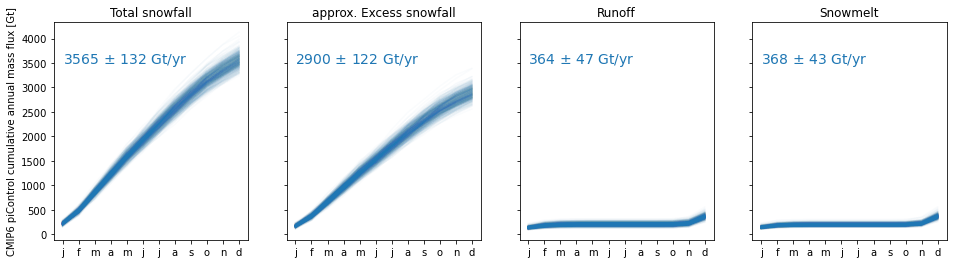

In [6]:
fig,ax = plt.subplots(1,4,figsize=(16,4),sharey=True)

var = {}
var[0] = SF
var[1] = SFex
var[2] = SF-SMB2
var[3] = SMB2-SMB
title = ['Total snowfall','approx. Excess snowfall','Runoff','Snowmelt']

for v in range(4):
    dum = np.zeros(499)
    for f in range(499):
        ax[v].plot(np.cumsum(var[v][f*12:(f+1)*12]),alpha=.02,c='tab:blue')
        dum[f] = np.sum(var[v][f*12:(f+1)*12])
    ax[v].text(0,3500,f"{np.mean(dum):.0f} $\pm$ {np.std(dum):.0f} Gt/yr",c='tab:blue',fontsize=14)
    ax[v].set_xticks(np.arange(12));
    ax[v].set_xticklabels(['j','f','m','a','m','j','j','a','s','o','n','d']);
    ax[v].set_title(title[v])
ax[0].set_ylabel('CMIP6 piControl cumulative annual mass flux [Gt]');
plt.savefig(f'../figures/snowfall_cmip6.png',dpi=450)
plt.show()